# Time Series Forecasting

This example shows using [Prophet](https://facebook.github.io/prophet/) and Dask for scalable time series forecasting.

> Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.

As discussed in the [*Forecasting at scale*](https://peerj.com/preprints/3190/), large datasets aren't the only type of scaling challenge teams run into. In this example we'll focus on one of the scaling challenges indentified in that paper:

> in most realistic settings, a large number of forecasts will be created, necessitating efficient, automated means of evaluating and comparing them, as well as detecting when they are likely to be performing poorly. When hundreds or even thousands of forecasts are made, it becomes important to let machines do the hard work of model evaluation and comparison while efficiently using human feedback to fix performance problems.

That sounds like a perfect opportunity for Dask. We'll use Prophet and Dask together to parallize the *diagnostics* stage of research. It does not attempt to parallize the training of the model itself.

In [1]:
# currently relies on Prophet master
# !pip install fbprophet

In [2]:
import pandas as pd
from fbprophet import Prophet

/Users/taugspurger/sandbox/prophet/python/fbprophet/diagnostics.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Importing plotly failed. Interactive plots will not work.


We'll walk through the example from the Prophet quickstart. These values represent the log daily page views for [Peyton Manning's wikipedia page](https://en.wikipedia.org/wiki/Peyton_Manning).

In [3]:
df = pd.read_csv(
    'https://raw.githubusercontent.com/facebook/prophet/master/examples/example_wp_log_peyton_manning.csv',
    parse_dates=['ds']
)
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


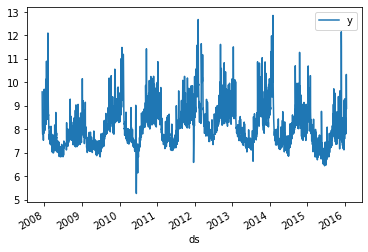

In [4]:
df.plot(x='ds', y='y');

Fitting the model takes a handful of seconds. Dask isn't involved at all here.

In [5]:
%%time
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 2.84 s, sys: 185 ms, total: 3.03 s
Wall time: 3.16 s


And we can make a forecast. Again, Dask isn't involved here.

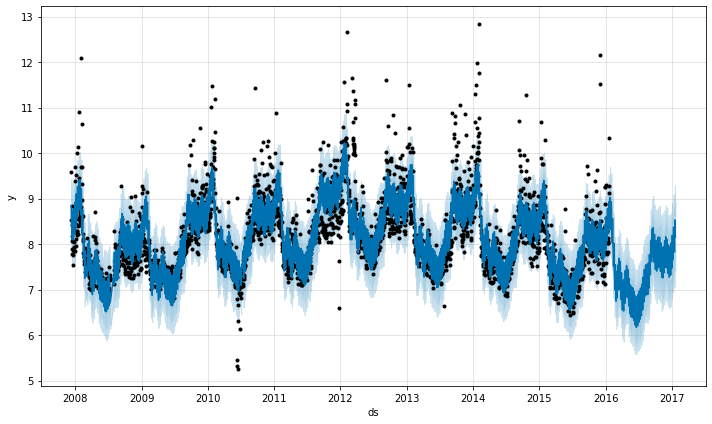

In [6]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
m.plot(forecast);

## Parallel Diagnostics

Prophet includes a `cross_validation` function method, which uses *simulated historical forecasts* to provide some idea of a model's quality.

> This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values.

See https://facebook.github.io/prophet/docs/diagnostics.html for more.

In [7]:
from fbprophet.diagnostics import cross_validation, performance_metrics

In [8]:
df_cv = cross_validation(m, initial="730 days", period="180 days", horizon="365 days")

INFO:fbprophet:Making 11 forecasts with cutoffs between 2010-02-15 00:00:00 and 2015-01-20 00:00:00


Internally, `cross_validation` determines some `cutoffs` based on the user's parameters to generate forecasts for. In this case, we ended up with 11. *The historical forecasts for each cutoff can be done entirely in parallel*. So in order to distribute cross validation, we'll just generate those cutoffs ourselves and call one `cross_validation` for each `cutoff`.

In [9]:
from fbprophet.diagnostics import generate_cutoffs

In [10]:
initial = pd.Timedelta("730 days")
period = pd.Timedelta("180 days")
horizon = pd.Timedelta("365 days")

cutoffs = generate_cutoffs(
    m.history.copy().reset_index(drop=True),
    horizon=horizon,
    initial=initial,
    period=period,
)
cutoffs

INFO:fbprophet:Making 11 forecasts with cutoffs between 2010-02-15 00:00:00 and 2015-01-20 00:00:00


[Timestamp('2010-02-15 00:00:00'),
 Timestamp('2010-08-14 00:00:00'),
 Timestamp('2011-02-10 00:00:00'),
 Timestamp('2011-08-09 00:00:00'),
 Timestamp('2012-02-05 00:00:00'),
 Timestamp('2012-08-03 00:00:00'),
 Timestamp('2013-01-30 00:00:00'),
 Timestamp('2013-07-29 00:00:00'),
 Timestamp('2014-01-25 00:00:00'),
 Timestamp('2014-07-24 00:00:00'),
 Timestamp('2015-01-20 00:00:00')]

We'll use `dask.delayed` and `fbprophet.diagnostics.single_cutoff_forecast` to lazily do all the cross validations.

In [11]:
import dask
from distributed import Client, performance_report

In [12]:
client = Client()
client

/Users/taugspurger/miniconda3/envs/prophet/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:57109 Dashboard: http://127.0.0.1:57110/status,Cluster Workers: 4 Cores: 8 Memory: 17.18 GB


In [13]:
from fbprophet.diagnostics import single_cutoff_forecast

In [14]:
delayed_cv = dask.delayed(single_cutoff_forecast)

# df2 is a somewhat large object.
df2 = dask.delayed(m.history.copy().reset_index(drop=True))
predict_columns = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']


cvs = [delayed_cv(df2, m, cutoff, horizon, predict_columns)
       for cutoff in cutoffs]
cvs

[Delayed('single_cutoff_forecast-2beefd29-c81c-418b-93d3-ba47c733a09e'),
 Delayed('single_cutoff_forecast-05e48834-1374-400b-81f3-64db1db2f61e'),
 Delayed('single_cutoff_forecast-4de065c1-1f81-4d6e-8bfe-8682d030b406'),
 Delayed('single_cutoff_forecast-51f8c837-57ee-44f9-89aa-ce4d92b72bd1'),
 Delayed('single_cutoff_forecast-fdcf70cb-f002-45f5-9d11-6297178808c1'),
 Delayed('single_cutoff_forecast-b5d96a17-e895-4cec-bb05-26cd8268d26a'),
 Delayed('single_cutoff_forecast-43bc36f0-33b7-4003-bc82-6dfb12718e6d'),
 Delayed('single_cutoff_forecast-c9bcb753-fe71-47ed-9235-d00486d553a5'),
 Delayed('single_cutoff_forecast-1d8b0c69-2f40-4636-ad3c-f87b26b537af'),
 Delayed('single_cutoff_forecast-b7515b9c-3abf-47e5-ad2e-1da7d40f9998'),
 Delayed('single_cutoff_forecast-6cd692d8-9248-409a-9d9e-08a83c1d5c37')]

In [15]:
client.scatter(df2);  # pre-scatter large data.

This finished instantly, since we haven't done anything yet.
By passing those to `dask.compute` the cluster will get to work.

In [16]:
# Watch the distributed Dashboard here
%time cvs = dask.compute(*cvs)

/Users/taugspurger/miniconda3/envs/prophet/lib/python3.7/site-packages/distributed/worker.py:3349: UserWarning: Large object of size 2.63 MB detected in task graph: 
  ('DataFrame-d5adf47d-5313-4aaa-93fa-a08c1711d4e5', ...  'yhat_upper'])
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


CPU times: user 1.03 s, sys: 176 ms, total: 1.2 s
Wall time: 22.5 s


This returns a list of DataFrames

In [17]:
cvs[0]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2010-02-16,8.960441,8.441521,9.480919,8.242493,2010-02-15
1,2010-02-17,8.726966,8.234586,9.228613,8.008033,2010-02-15
2,2010-02-18,8.610869,8.141561,9.129617,8.045268,2010-02-15
3,2010-02-19,8.532795,8.042013,9.026715,7.928766,2010-02-15
4,2010-02-20,8.274904,7.786199,8.804688,7.745003,2010-02-15
...,...,...,...,...,...,...
352,2011-02-11,10.304632,9.763324,10.891173,8.159089,2010-02-15
353,2011-02-12,10.036605,9.461822,10.605747,7.913521,2010-02-15
354,2011-02-13,10.350795,9.840123,10.905335,7.840706,2010-02-15
355,2011-02-14,10.553689,10.002035,11.133023,8.024862,2010-02-15


Which we can concatenate to get the same result as the original.

In [18]:
df_cv = pd.concat(cvs, ignore_index=True)
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2010-02-16,8.960441,8.441521,9.480919,8.242493,2010-02-15
1,2010-02-17,8.726966,8.234586,9.228613,8.008033,2010-02-15
2,2010-02-18,8.610869,8.141561,9.129617,8.045268,2010-02-15
3,2010-02-19,8.532795,8.042013,9.026715,7.928766,2010-02-15
4,2010-02-20,8.274904,7.786199,8.804688,7.745003,2010-02-15
...,...,...,...,...,...,...
3983,2016-01-16,8.580395,7.889739,9.294868,7.817223,2015-01-20
3984,2016-01-17,8.975041,8.246793,9.726330,9.273878,2015-01-20
3985,2016-01-18,9.281189,8.562223,9.992537,10.333775,2015-01-20
3986,2016-01-19,9.064340,8.375026,9.731277,9.125871,2015-01-20


At this point, we're back to the same result as if we had done things without Dask.
We can compute `performance_metrics`.

In [19]:
from fbprophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,0.495161,0.703677,0.505237,0.058536,0.049506,0.684102
1,38 days,0.500957,0.707783,0.510231,0.059114,0.049314,0.682960
2,39 days,0.523235,0.723350,0.516340,0.059715,0.049389,0.680219
3,40 days,0.530583,0.728411,0.519241,0.060026,0.049254,0.683874
4,41 days,0.538145,0.733584,0.520267,0.060108,0.049314,0.691412
...,...,...,...,...,...,...,...
324,361 days,1.122104,1.059294,0.857679,0.102812,0.087348,0.497031
325,362 days,1.137636,1.066600,0.864303,0.103414,0.088498,0.495203
326,363 days,1.159084,1.076608,0.871785,0.104175,0.088498,0.492005
327,364 days,1.175737,1.084314,0.879437,0.105107,0.089394,0.486295


And plot, e.g. the mean absolute percent error.

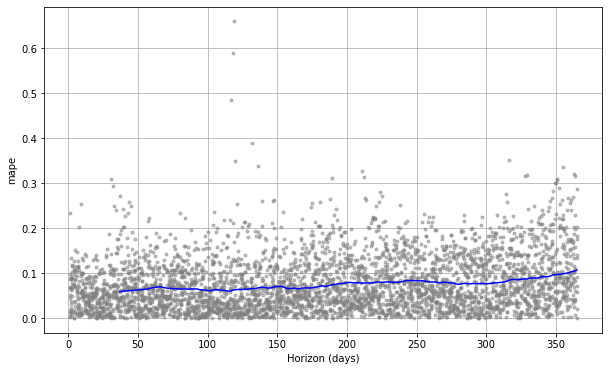

In [20]:
from fbprophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv, metric='mape')

## Things to improve

Currently, this requires a bit of specialized knowledge to use correctly.
It took me (a light user of Prophet) a bit of time to dig into Prophet's source code to determine the appropriate point of parallelization. And it takes a bit of Dask knowledge to know just what should be wrapped in `dask.delayed`.

Currently, Prophet supports parallel evaluation in `cross_validation` with `multiprocessing`. It would be great if Prophet could do things using an interface like `concurrent.futures`. Then users could choose their own parallelism.


```python
from concurrent.futures import ThreadPoolExecutor


# Parallelize with Threads
cross_validation(model, executor=ThreadPoolExecutor())

# Parallelize with Dask
cross_validation(model, executor=client)
```

However, there are a few issues that would need to be solved upstream in Python itself (see https://github.com/dask/distributed/issues/3695) for more. For now, this post serves as a reference for a way to achieve parallel, distributed diagnostics usings Prophet's already great API.